In [1]:
import sys

sys.path.append("..") if ".." not in sys.path else print("Already exists")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as F
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from torchvision import models
from torchvision import transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from tqdm.notebook import tqdm

from utils.dataset import get_dataloader
from utils.training import TrainingInterface, print_total_params, train_network
from utils.plots import EvaluationPlots

### Load Dataset

In [2]:
df = pd.read_csv("../data/transformation_split.csv")

### Initiate Dataloaders

In [3]:
further_transforms = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225]),
    ]
)

In [4]:
dataloader_train = get_dataloader(
    root_dir="../data/prepared_images/",
    df=df[df["set"] == "train"].drop_duplicates(),
    transformations=further_transforms,
    batch_size=32,
    workers=12,
    pin_memory=True,
)
dataloader_val = get_dataloader(
    root_dir="../data/prepared_images/",
    df=df[df["set"] == "val"].drop_duplicates(),
    transformations=further_transforms,
    batch_size=32,
    workers=12,
    pin_memory=True,
)
dataloader_test = get_dataloader(
    root_dir="../data/prepared_images/",
    df=df[df["set"] == "test"].drop_duplicates(),
    transformations=further_transforms,
    batch_size=32,
    workers=12,
    pin_memory=True,
)

### Check Dataloader Batch

In [5]:
# Plot batch
check_batch = False

plt.rcParams["savefig.bbox"] = "tight"

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(12, 20))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


if check_batch:
    batch = next(iter(dataloader_train))
    batch, label = batch
    show(make_grid(batch, nrow=int(len(batch) / 4)))

# ConvNext

## Transfer-Learning

In [6]:
convnext_tiny_ = models.convnext_tiny(pretrained=True, progress=True)

In [7]:
print(convnext_tiny_)

ConvNeXt(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU()
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384

In [8]:
for param in convnext_tiny_.parameters():
    param.requires_grad = False

convnext_tiny_.classifier[2] = nn.Linear(
    in_features=768, out_features=len(dataloader_train.dataset.label_dict.keys())
)

for param in convnext_tiny_.classifier.parameters():
    param.requires_grad = False
    print(param.requires_grad)

# Set requires grad for FC weights
convnext_tiny_.classifier[2].weight.requires_grad = True
convnext_tiny_.classifier[2].bias.requires_grad = True

False
False
False
False


In [9]:
# Check
for name, param in convnext_tiny_.named_parameters():
    if param.requires_grad:
        print(name)

classifier.2.weight
classifier.2.bias


In [10]:
convnext = TrainingInterface(model=convnext_tiny_, name="ConvNext Tiny")

In [11]:
convnext.print_total_params()

ConvNext Tiny | Trainable Parameters: 27830125


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(convnext.model.parameters(), lr=0.001)

In [13]:
convnext.train(
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=2,
    dataloader_train=dataloader_train,
    dataloader_val=dataloader_val,
    verbose=True
)

  0%|          | 0/642 [00:00<?, ?it/s]

Epoch 1/2: [Train-Loss = 374.233] || [Validation-Loss = 30.162]
Epoch 2/2: [Train-Loss = 247.626] || [Validation-Loss = 33.693]


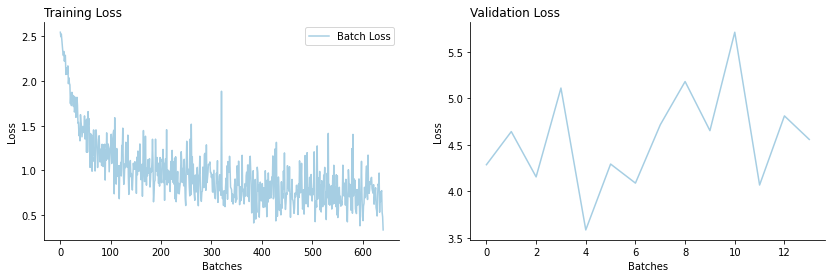

In [14]:
EvaluationPlots.plot_train_val_loss(convnext.train_losses, 
                                    convnext.eval_losses, 
                                    convnext.epoch_loss)

In [16]:
metrics = convnext.calculate_metrics(dataloader_train=dataloader_train, 
                                     dataloader_test=dataloader_test, 
                                     metric_funcs=[precision_score, recall_score], 
                                     average='macro')

Get Predictions on Trainset:   0%|          | 0/321 [00:00<?, ?it/s]

Get Predictins on Testset:   0%|          | 0/7 [00:00<?, ?it/s]

/users/sstaehli/manhole-cover-classification/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'train': {'precision_score': 0.8383480706608034,
  'recall_score': 0.828642782120913},
 'test': {'precision_score': 0.026082664380536722,
  'recall_score': 0.12130177514792899}}

In [18]:
y_true, y_pred = convnext.predict(dataloader_test)

Calculate Predictions:   0%|          | 0/7 [00:00<?, ?it/s]

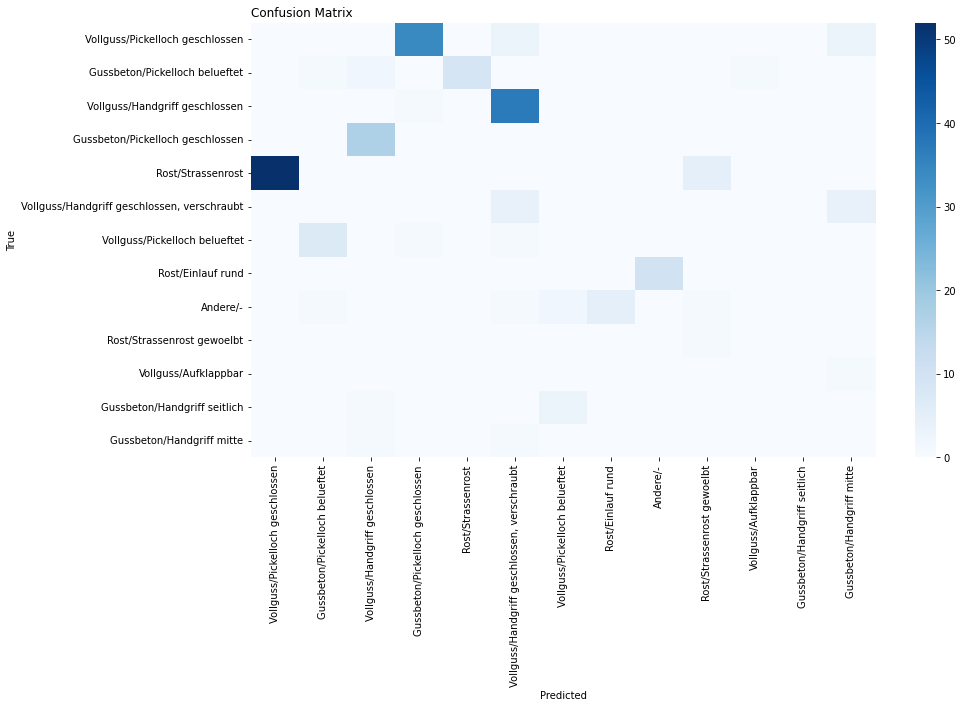

In [23]:
EvaluationPlots.plot_confusion_matrix(y_true, y_pred, dataloader_test.dataset.label_dict_r)

## No Transfer-Learning

In [25]:
convnext_tiny_ = models.convnext_tiny(pretrained=False, progress=True)

In [26]:
for param in convnext_tiny_.parameters():
    param.requires_grad = True

In [28]:
convnext_nopre = TrainingInterface(model=convnext_tiny_, name='ConvNext Tiny Not Pretrained') 

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(convnext.model.parameters(), lr=0.001)

In [30]:
convnext.train(
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=5,
    dataloader_train=dataloader_train,
    dataloader_val=dataloader_val,
    verbose=True
)

  0%|          | 0/1605 [00:00<?, ?it/s]

Epoch 1/5: [Train-Loss = 215.001] || [Validation-Loss = 36.201]
Epoch 2/5: [Train-Loss = 191.855] || [Validation-Loss = 38.039]
Epoch 3/5: [Train-Loss = 177.179] || [Validation-Loss = 39.034]
Epoch 4/5: [Train-Loss = 167.606] || [Validation-Loss = 39.911]
Epoch 5/5: [Train-Loss = 158.043] || [Validation-Loss = 40.679]


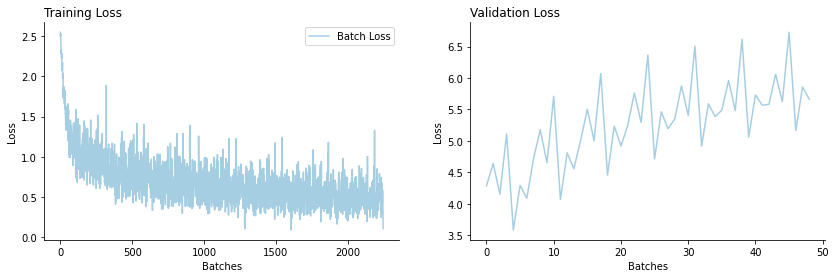

In [31]:
EvaluationPlots.plot_train_val_loss(convnext.train_losses, 
                                    convnext.eval_losses, 
                                    convnext.epoch_loss)

## AlexNet

### Pretrained

In [32]:
alexnet_ = models.alexnet(pretrained=False, progress=True)

In [33]:
alexnet_.classifier[6] = nn.Linear(4096, len(dataloader_train.dataset.label_dict.keys()))

In [34]:
# Switch off grads for all layers
for param in alexnet_.parameters():
    param.requires_grad = True

In [35]:
# Switch on gradients for classifer
for name, param in alexnet_.named_parameters():
    if 'classifier' in name:
        param.requires_grad = True
        print(name)

classifier.1.weight
classifier.1.bias
classifier.4.weight
classifier.4.bias
classifier.6.weight
classifier.6.bias


In [36]:
alexnet = TrainingInterface(model=alexnet_, name='Alex Net')

In [37]:
criterion = nn.CrossEntropyLoss()

In [38]:
optimizer = optim.Adam(alexnet.model.parameters(), lr=0.001)

In [39]:
alexnet.train(
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=5,
    dataloader_train=dataloader_train,
    dataloader_val=dataloader_val,
    verbose=True
)

  0%|          | 0/1605 [00:00<?, ?it/s]

Epoch 1/5: [Train-Loss = 700.21] || [Validation-Loss = 32.111]
Epoch 2/5: [Train-Loss = 545.681] || [Validation-Loss = 39.701]
Epoch 3/5: [Train-Loss = 468.073] || [Validation-Loss = 38.375]
Epoch 4/5: [Train-Loss = 421.555] || [Validation-Loss = 41.709]
Epoch 5/5: [Train-Loss = 392.95] || [Validation-Loss = 43.99]


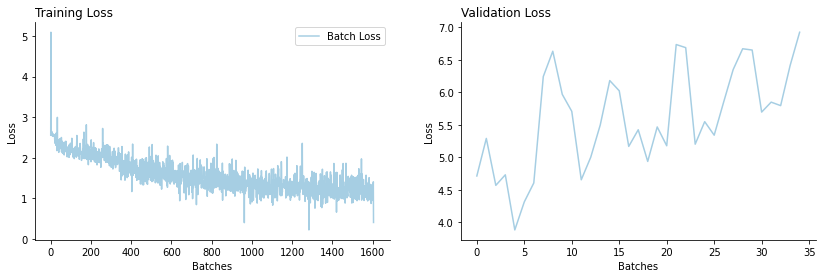

In [40]:
EvaluationPlots.plot_train_val_loss(alexnet.train_losses, 
                                    alexnet.eval_losses, 
                                    alexnet.epoch_loss, )

### Not Pretrained

## ResNet18

### Pretrained

In [81]:
resnet_ = models.resnet18(pretrained=True, progress=True)

In [82]:
print(resnet_)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [83]:
for param in resnet_.parameters():
    param.requires_grad = False

# Replace fc
resnet_.fc = nn.Linear(512, len(dataloader_train.dataset.label_dict.keys()))

# Enable grad
resnet_.fc.weight.requires_grad = True
resnet_.fc.bias.requires_grad = True

# check
for name, param in resnet_.named_parameters():
    if param.requires_grad:
        print('Requires Grad:', name)

Requires Grad: fc.weight
Requires Grad: fc.bias


In [84]:
resnet = TrainingInterface(model=resnet_, name='ResNet18 pretrained')

In [85]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.model.parameters(), lr=.000008)

  0%|          | 0/1605 [00:00<?, ?it/s]

Epoch 1/5: [Train-Loss = 849.339] || [Validation-Loss = 18.523]
Epoch 2/5: [Train-Loss = 806.952] || [Validation-Loss = 18.462]
Epoch 3/5: [Train-Loss = 779.605] || [Validation-Loss = 18.53]
Epoch 4/5: [Train-Loss = 755.081] || [Validation-Loss = 18.638]
Epoch 5/5: [Train-Loss = 732.244] || [Validation-Loss = 18.774]


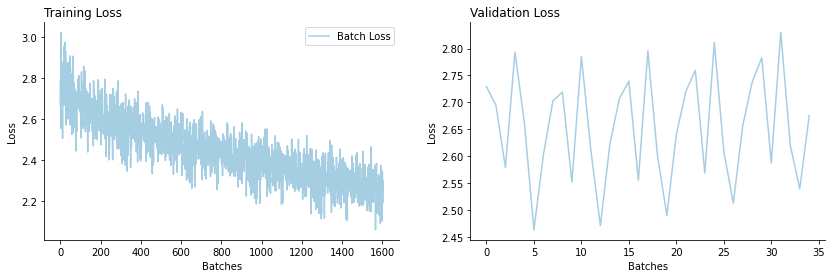

In [86]:
resnet.train(
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=5,
    dataloader_train=dataloader_train,
    dataloader_val=dataloader_val,
    verbose=True
)
EvaluationPlots.plot_train_val_loss(resnet.train_losses, resnet.eval_losses, 'asdf')